# Benchmarking Matrix generation script

Important remarks :

- Approximation results as the load of the active ui animation is hard to simulate aside the matrix calculation. Currently a large animation with 0.5 boat is run beside this script

- Number of time deltas per combination is chosen arbitrarily, 10 in this case, for the sake of simplicity, it is totally possible for a data to be more heavy on a specific time range that may not be covered in the selected deltas

In [10]:
import numpy as np
from shapely.geometry import Point
from pymeos.db.psycopg import MobilityDB

from pymeos import *
import os
import sys
from datetime import timedelta, datetime
from pymeos import *
import time
from tqdm import tqdm
import itertools
import shutil
import math
import subprocess
from collections import deque



In [11]:

def get_folder_size_mb(dir_name):
    total_size = 0
    sizes = deque(maxlen=3)
    for dirpath, dirnames, filenames in os.walk(dir_name):
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)
            # Skip if it is symbolic link
            if not os.path.islink(file_path):
                sizes.append(os.path.getsize(file_path))
    # Convert size to MB
    total_size_mb = sum(sizes) / (1024 * 1024)
    return total_size_mb


In [12]:


"""
Iterate over all the possible combinations of frames and percentages

for each combination :
    
    Create 3 time deltas
    store : time for each time delta
    store : maximum time for each time delta
    store : average time for each time delta
    
    Calculate FPS using : Frames / maximum time for each time delta

    Store the FPS for each combination

    store the memory used by all 3 time delta in local disk


"""


MATRIX_DIRECTORY_PATH ="/home/ali/matrices/" 
if os.path.exists(MATRIX_DIRECTORY_PATH):
    shutil.rmtree(MATRIX_DIRECTORY_PATH)
    os.makedirs(MATRIX_DIRECTORY_PATH)
else:
    os.makedirs(MATRIX_DIRECTORY_PATH)
pymeos_initialize()

SRID = 4326
DATABASE_NAME = "mobilitydb"
TPOINT_TABLE_NAME = "PyMEOS_demo"
TPOINT_ID_COLUMN_NAME = "MMSI"
TPOINT_COLUMN_NAME = "trajectory"
x_min = -180
y_min = -90
x_max = 180
y_max = 90
extent_list = [x_min, y_min, x_max, y_max]
Time_granularities = {
                    # "MILLISECOND" : timedelta(milliseconds=1),
                      "SECOND" : timedelta(seconds=1),
                      "MINUTE" : timedelta(minutes=1),
                    #   "HOUR" : timedelta(hours=1),
                    }
GRANULARITY = Time_granularities["SECOND"]

connection_params = {
        "host": "localhost",
        "port": 5432,
        "dbname": DATABASE_NAME,
        "user": "postgres",
        "password": "postgres"
        }
                
connection = MobilityDB.connect(**connection_params)
cursor = connection.cursor()

cursor.execute(f"SELECT {TPOINT_ID_COLUMN_NAME} FROM public.{TPOINT_TABLE_NAME};")
Total_ids = cursor.fetchall()

cursor.execute(f"SELECT MIN(startTimestamp({TPOINT_COLUMN_NAME})) AS earliest_timestamp FROM public.{TPOINT_TABLE_NAME};")
start_date = cursor.fetchone()[0]
cursor.execute(f"SELECT MAX(endTimestamp({TPOINT_COLUMN_NAME})) AS latest_timestamp FROM public.{TPOINT_TABLE_NAME};")
end_date = cursor.fetchone()[0]

total_frames = math.ceil( (end_date - start_date) // GRANULARITY ) + 1

timestamps = [start_date + i * GRANULARITY for i in range(total_frames)]
timestamps = [dt.replace(tzinfo=None) for dt in timestamps]
timestamps_strings = [dt.strftime('%Y-%m-%d %H:%M:%S') for dt in timestamps]


TIME_DELTA_COUNT = 10


Frames = [10, 60, 120, 240, 480, 960]
Percentages = [0.1, 0.5,  1]

number_of_objects={} # Store the number of objects for each percentage
times = {} # Store the time for each time delta
memory_used = {} # Store the memory used for each combination

combinations = tqdm(list(itertools.product(Frames, Percentages)))

for combination in combinations:
    combinations.set_description(f"Combination {combination}")
    frame, percentage = combination

    
    ids_list = Total_ids[:int(len(Total_ids)*percentage)]
    number_of_objects[percentage] = len(ids_list)


    # print(combination)
    dir_name = f"/home/ali/matrices/{frame}_{percentage}"
    # print(dir_name)
    os.mkdir(dir_name)
   
    t_deltas = tqdm([(i, (i+frame)-1) for i in range(0, 10*frame, frame)]) 
    # print(t_deltas)
    times[combination] = []
    for delta in t_deltas:
        t_deltas.set_description(f"Time delta {delta}")
        now = time.time()
        x_min,y_min, x_max, y_max = extent_list
        begin_frame, end_frame = delta
        arguments = [begin_frame, end_frame, percentage, x_min, y_min, x_max, y_max]
        arguments = [str(arg) for arg in arguments]
        arguments += [timestamps_strings[begin_frame],  str(len(timestamps)),
                'SECOND',
                dir_name,
                'mobilitydb',
                'pymeos_demo',
                'MMSI',
                'trajectory']
     

        python_path = sys.executable
        process_B_path = f"/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py"
        
        command = [python_path, process_B_path, *arguments]
        result = subprocess.run(command, capture_output=True, text=True)
        print(result)
        
        loaded_matrix = np.load(f"{dir_name}/matrix_{begin_frame}.npy", allow_pickle=True)

        TIME_total = time.time() - now
        times[combination].append(TIME_total)
    size = get_folder_size_mb(dir_name) 
    memory_used[combination] = size
    shutil.rmtree(dir_name)
        
    
    



Combination (10, 0.1):   0%|          | 0/18 [00:00<?, ?it/s]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '0', '9', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/10_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 0.009778022766113281 seconds, 0.29334068298339844 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '10', '19', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:00:10', '86399', 'SECOND', '/home/ali/matrices/10_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 10 created in 0.01663041114807129 seconds, 0.49891233444213867 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '20', '29', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:00:20', '86399', 'SECOND', '/home/ali/matrices/10_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 20 created in 0.01837611198425293 seconds, 0.5512833595275879 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '30', '39', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:00:30', '86399', 'SECOND', '/home/ali/matrices/10_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 30 created in 0.019721269607543945 seconds, 0.5916380882263184 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '40', '49', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:00:40', '86399', 'SECOND', '/home/ali/matrices/10_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 40 created in 0.023862838745117188 seconds, 0.7158851623535156 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '50', '59', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:00:50', '86399', 'SECOND', '/home/ali/matrices/10_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 50 created in 0.023167133331298828 seconds, 0.6950139999389648 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '60', '69', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:01:00', '86399', 'SECOND', '/home/ali/matrices/10_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 60 created in 0.025062084197998047 seconds, 0.7518625259399414 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '70', '79', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:01:10', '86399', 'SECOND', '/home/ali/matrices/10_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 70 created in 0.028313636779785156 seconds, 0.8494091033935547 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '80', '89', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:01:20', '86399', 'SECOND', '/home/ali/matrices/10_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 80 created in 0.029167652130126953 seconds, 0.8750295639038086 frames for 30 fps animation.\n', stderr='')


Combination (10, 0.5):   6%|▌         | 1/18 [00:02<00:45,  2.69s/it]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '90', '99', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:01:30', '86399', 'SECOND', '/home/ali/matrices/10_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 90 created in 0.03046274185180664 seconds, 0.9138822555541992 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '0', '9', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/10_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 0.06169581413269043 seconds, 1.850874423980713 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '10', '19', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:00:10', '86399', 'SECOND', '/home/ali/matrices/10_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 10 created in 0.1026163101196289 seconds, 3.078489303588867 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '20', '29', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:00:20', '86399', 'SECOND', '/home/ali/matrices/10_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 20 created in 0.129256010055542 seconds, 3.8776803016662598 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '30', '39', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:00:30', '86399', 'SECOND', '/home/ali/matrices/10_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 30 created in 0.1503140926361084 seconds, 4.509422779083252 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '40', '49', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:00:40', '86399', 'SECOND', '/home/ali/matrices/10_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 40 created in 0.15063047409057617 seconds, 4.518914222717285 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '50', '59', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:00:50', '86399', 'SECOND', '/home/ali/matrices/10_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 50 created in 0.16493916511535645 seconds, 4.948174953460693 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '60', '69', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:01:00', '86399', 'SECOND', '/home/ali/matrices/10_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 60 created in 0.18639612197875977 seconds, 5.591883659362793 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '70', '79', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:01:10', '86399', 'SECOND', '/home/ali/matrices/10_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 70 created in 0.194993257522583 seconds, 5.84979772567749 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '80', '89', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:01:20', '86399', 'SECOND', '/home/ali/matrices/10_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 80 created in 0.20849013328552246 seconds, 6.254703998565674 frames for 30 fps animation.\n', stderr='')


Combination (10, 1):  11%|█         | 2/18 [00:07<01:03,  3.98s/it]  

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '90', '99', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:01:30', '86399', 'SECOND', '/home/ali/matrices/10_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 90 created in 0.21628785133361816 seconds, 6.488635540008545 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '0', '9', '1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/10_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 0.14246344566345215 seconds, 4.2739033699035645 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '10', '19', '1', '-180', '-90', '180', '90', '2023-06-01 00:00:10', '86399', 'SECOND', '/home/ali/matrices/10_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 10 created in 0.25038719177246094 seconds, 7.511615753173828 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '20', '29', '1', '-180', '-90', '180', '90', '2023-06-01 00:00:20', '86399', 'SECOND', '/home/ali/matrices/10_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 20 created in 0.30260157585144043 seconds, 9.078047275543213 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '30', '39', '1', '-180', '-90', '180', '90', '2023-06-01 00:00:30', '86399', 'SECOND', '/home/ali/matrices/10_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 30 created in 0.30095338821411133 seconds, 9.02860164642334 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '40', '49', '1', '-180', '-90', '180', '90', '2023-06-01 00:00:40', '86399', 'SECOND', '/home/ali/matrices/10_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 40 created in 0.33098769187927246 seconds, 9.929630756378174 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '50', '59', '1', '-180', '-90', '180', '90', '2023-06-01 00:00:50', '86399', 'SECOND', '/home/ali/matrices/10_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 50 created in 0.3666696548461914 seconds, 11.000089645385742 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '60', '69', '1', '-180', '-90', '180', '90', '2023-06-01 00:01:00', '86399', 'SECOND', '/home/ali/matrices/10_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 60 created in 0.3920319080352783 seconds, 11.76095724105835 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '70', '79', '1', '-180', '-90', '180', '90', '2023-06-01 00:01:10', '86399', 'SECOND', '/home/ali/matrices/10_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 70 created in 0.3967912197113037 seconds, 11.903736591339111 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '80', '89', '1', '-180', '-90', '180', '90', '2023-06-01 00:01:20', '86399', 'SECOND', '/home/ali/matrices/10_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 80 created in 0.4398012161254883 seconds, 13.194036483764648 frames for 30 fps animation.\n', stderr='')


Combination (60, 0.1):  17%|█▋        | 3/18 [00:16<01:31,  6.07s/it]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '90', '99', '1', '-180', '-90', '180', '90', '2023-06-01 00:01:30', '86399', 'SECOND', '/home/ali/matrices/10_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 90 created in 0.45144176483154297 seconds, 13.543252944946289 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '0', '59', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/60_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 0.05389571189880371 seconds, 1.6168713569641113 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '60', '119', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:01:00', '86399', 'SECOND', '/home/ali/matrices/60_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 60 created in 0.10283851623535156 seconds, 3.085155487060547 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '120', '179', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:02:00', '86399', 'SECOND', '/home/ali/matrices/60_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 120 created in 0.11842870712280273 seconds, 3.552861213684082 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '180', '239', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:03:00', '86399', 'SECOND', '/home/ali/matrices/60_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 180 created in 0.12064385414123535 seconds, 3.6193156242370605 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '240', '299', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:04:00', '86399', 'SECOND', '/home/ali/matrices/60_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 240 created in 0.12969398498535156 seconds, 3.890819549560547 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '300', '359', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:05:00', '86399', 'SECOND', '/home/ali/matrices/60_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 300 created in 0.1335153579711914 seconds, 4.005460739135742 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '360', '419', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:06:00', '86399', 'SECOND', '/home/ali/matrices/60_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 360 created in 0.15224289894104004 seconds, 4.567286968231201 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '420', '479', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:07:00', '86399', 'SECOND', '/home/ali/matrices/60_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 420 created in 0.14472126960754395 seconds, 4.341638088226318 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '480', '539', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:08:00', '86399', 'SECOND', '/home/ali/matrices/60_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 480 created in 0.13988256454467773 seconds, 4.196476936340332 frames for 30 fps animation.\n', stderr='')


Combination (60, 0.5):  22%|██▏       | 4/18 [00:19<01:12,  5.15s/it]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '540', '599', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:09:00', '86399', 'SECOND', '/home/ali/matrices/60_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 540 created in 0.1428663730621338 seconds, 4.285991191864014 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '0', '59', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/60_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 0.37523555755615234 seconds, 11.25706672668457 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '60', '119', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:01:00', '86399', 'SECOND', '/home/ali/matrices/60_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 60 created in 0.7190942764282227 seconds, 21.57282829284668 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '120', '179', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:02:00', '86399', 'SECOND', '/home/ali/matrices/60_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 120 created in 0.8075134754180908 seconds, 24.225404262542725 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '180', '239', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:03:00', '86399', 'SECOND', '/home/ali/matrices/60_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 180 created in 0.876838207244873 seconds, 26.30514621734619 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '240', '299', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:04:00', '86399', 'SECOND', '/home/ali/matrices/60_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 240 created in 0.8632376194000244 seconds, 25.897128582000732 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '300', '359', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:05:00', '86399', 'SECOND', '/home/ali/matrices/60_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 300 created in 0.900322675704956 seconds, 27.00968027114868 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '360', '419', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:06:00', '86399', 'SECOND', '/home/ali/matrices/60_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 360 created in 0.9159700870513916 seconds, 27.479102611541748 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '420', '479', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:07:00', '86399', 'SECOND', '/home/ali/matrices/60_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 420 created in 0.9514551162719727 seconds, 28.54365348815918 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '480', '539', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:08:00', '86399', 'SECOND', '/home/ali/matrices/60_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 480 created in 0.9124624729156494 seconds, 27.373874187469482 frames for 30 fps animation.\n', stderr='')


Combination (60, 1):  28%|██▊       | 5/18 [00:31<01:38,  7.57s/it]  

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '540', '599', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:09:00', '86399', 'SECOND', '/home/ali/matrices/60_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 540 created in 0.9536397457122803 seconds, 28.609192371368408 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '0', '59', '1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/60_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 0.8593194484710693 seconds, 25.77958345413208 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '60', '119', '1', '-180', '-90', '180', '90', '2023-06-01 00:01:00', '86399', 'SECOND', '/home/ali/matrices/60_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 60 created in 1.522144079208374 seconds, 45.66432237625122 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '120', '179', '1', '-180', '-90', '180', '90', '2023-06-01 00:02:00', '86399', 'SECOND', '/home/ali/matrices/60_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 120 created in 1.7426931858062744 seconds, 52.28079557418823 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '180', '239', '1', '-180', '-90', '180', '90', '2023-06-01 00:03:00', '86399', 'SECOND', '/home/ali/matrices/60_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 180 created in 1.843865156173706 seconds, 55.31595468521118 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '240', '299', '1', '-180', '-90', '180', '90', '2023-06-01 00:04:00', '86399', 'SECOND', '/home/ali/matrices/60_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 240 created in 1.8792307376861572 seconds, 56.37692213058472 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '300', '359', '1', '-180', '-90', '180', '90', '2023-06-01 00:05:00', '86399', 'SECOND', '/home/ali/matrices/60_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 300 created in 1.8316740989685059 seconds, 54.950222969055176 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '360', '419', '1', '-180', '-90', '180', '90', '2023-06-01 00:06:00', '86399', 'SECOND', '/home/ali/matrices/60_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 360 created in 1.8974626064300537 seconds, 56.92387819290161 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '420', '479', '1', '-180', '-90', '180', '90', '2023-06-01 00:07:00', '86399', 'SECOND', '/home/ali/matrices/60_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 420 created in 1.862928867340088 seconds, 55.88786602020264 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '480', '539', '1', '-180', '-90', '180', '90', '2023-06-01 00:08:00', '86399', 'SECOND', '/home/ali/matrices/60_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 480 created in 1.8757243156433105 seconds, 56.271729469299316 frames for 30 fps animation.\n', stderr='')


Combination (120, 0.1):  33%|███▎      | 6/18 [00:54<02:33, 12.77s/it]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '540', '599', '1', '-180', '-90', '180', '90', '2023-06-01 00:09:00', '86399', 'SECOND', '/home/ali/matrices/60_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 540 created in 1.938624382019043 seconds, 58.15873146057129 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '0', '119', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/120_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 0.11936163902282715 seconds, 3.5808491706848145 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '120', '239', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:02:00', '86399', 'SECOND', '/home/ali/matrices/120_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 120 created in 0.22229719161987305 seconds, 6.668915748596191 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '240', '359', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:04:00', '86399', 'SECOND', '/home/ali/matrices/120_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 240 created in 0.24147963523864746 seconds, 7.244389057159424 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '360', '479', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:06:00', '86399', 'SECOND', '/home/ali/matrices/120_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 360 created in 0.25955700874328613 seconds, 7.786710262298584 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '480', '599', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:08:00', '86399', 'SECOND', '/home/ali/matrices/120_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 480 created in 0.27828168869018555 seconds, 8.348450660705566 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '600', '719', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:10:00', '86399', 'SECOND', '/home/ali/matrices/120_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 600 created in 0.2802095413208008 seconds, 8.406286239624023 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '720', '839', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:12:00', '86399', 'SECOND', '/home/ali/matrices/120_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 720 created in 0.2745487689971924 seconds, 8.236463069915771 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '840', '959', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:14:00', '86399', 'SECOND', '/home/ali/matrices/120_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 840 created in 0.2808365821838379 seconds, 8.425097465515137 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '960', '1079', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:16:00', '86399', 'SECOND', '/home/ali/matrices/120_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 960 created in 0.3078880310058594 seconds, 9.236640930175781 frames for 30 fps animation.\n', stderr='')


Combination (120, 0.5):  39%|███▉      | 7/18 [00:59<01:53, 10.27s/it]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1080', '1199', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:18:00', '86399', 'SECOND', '/home/ali/matrices/120_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1080 created in 0.29743385314941406 seconds, 8.923015594482422 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '0', '119', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/120_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 0.8915250301361084 seconds, 26.745750904083252 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '120', '239', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:02:00', '86399', 'SECOND', '/home/ali/matrices/120_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 120 created in 1.602489709854126 seconds, 48.07469129562378 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '240', '359', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:04:00', '86399', 'SECOND', '/home/ali/matrices/120_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 240 created in 1.6878132820129395 seconds, 50.634398460388184 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '360', '479', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:06:00', '86399', 'SECOND', '/home/ali/matrices/120_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 360 created in 1.7193007469177246 seconds, 51.57902240753174 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '480', '599', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:08:00', '86399', 'SECOND', '/home/ali/matrices/120_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 480 created in 1.749770164489746 seconds, 52.49310493469238 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '600', '719', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:10:00', '86399', 'SECOND', '/home/ali/matrices/120_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 600 created in 1.8816864490509033 seconds, 56.4505934715271 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '720', '839', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:12:00', '86399', 'SECOND', '/home/ali/matrices/120_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 720 created in 1.840423345565796 seconds, 55.21270036697388 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '840', '959', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:14:00', '86399', 'SECOND', '/home/ali/matrices/120_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 840 created in 1.8121764659881592 seconds, 54.365293979644775 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '960', '1079', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:16:00', '86399', 'SECOND', '/home/ali/matrices/120_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 960 created in 1.8246612548828125 seconds, 54.739837646484375 frames for 30 fps animation.\n', stderr='')


Combination (120, 1):  44%|████▍     | 8/18 [01:20<02:15, 13.57s/it]  

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1080', '1199', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:18:00', '86399', 'SECOND', '/home/ali/matrices/120_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1080 created in 1.8160789012908936 seconds, 54.48236703872681 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '0', '119', '1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/120_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 1.8852660655975342 seconds, 56.557981967926025 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '120', '239', '1', '-180', '-90', '180', '90', '2023-06-01 00:02:00', '86399', 'SECOND', '/home/ali/matrices/120_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 120 created in 3.137432813644409 seconds, 94.12298440933228 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '240', '359', '1', '-180', '-90', '180', '90', '2023-06-01 00:04:00', '86399', 'SECOND', '/home/ali/matrices/120_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 240 created in 3.296189546585083 seconds, 98.88568639755249 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '360', '479', '1', '-180', '-90', '180', '90', '2023-06-01 00:06:00', '86399', 'SECOND', '/home/ali/matrices/120_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 360 created in 3.4273338317871094 seconds, 102.82001495361328 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '480', '599', '1', '-180', '-90', '180', '90', '2023-06-01 00:08:00', '86399', 'SECOND', '/home/ali/matrices/120_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 480 created in 3.5886619091033936 seconds, 107.6598572731018 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '600', '719', '1', '-180', '-90', '180', '90', '2023-06-01 00:10:00', '86399', 'SECOND', '/home/ali/matrices/120_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 600 created in 3.631411552429199 seconds, 108.94234657287598 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '720', '839', '1', '-180', '-90', '180', '90', '2023-06-01 00:12:00', '86399', 'SECOND', '/home/ali/matrices/120_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 720 created in 3.6253137588500977 seconds, 108.75941276550293 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '840', '959', '1', '-180', '-90', '180', '90', '2023-06-01 00:14:00', '86399', 'SECOND', '/home/ali/matrices/120_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 840 created in 3.6887729167938232 seconds, 110.6631875038147 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '960', '1079', '1', '-180', '-90', '180', '90', '2023-06-01 00:16:00', '86399', 'SECOND', '/home/ali/matrices/120_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 960 created in 3.6806771755218506 seconds, 110.42031526565552 frames for 30 fps animation.\n', stderr='')


Combination (240, 0.1):  50%|█████     | 9/18 [02:00<03:16, 21.80s/it]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1080', '1199', '1', '-180', '-90', '180', '90', '2023-06-01 00:18:00', '86399', 'SECOND', '/home/ali/matrices/120_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1080 created in 3.7275443077087402 seconds, 111.8263292312622 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '0', '239', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/240_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 0.3079061508178711 seconds, 9.237184524536133 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '240', '479', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:04:00', '86399', 'SECOND', '/home/ali/matrices/240_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 240 created in 0.4624321460723877 seconds, 13.87296438217163 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '480', '719', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:08:00', '86399', 'SECOND', '/home/ali/matrices/240_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 480 created in 0.5143754482269287 seconds, 15.431263446807861 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '720', '959', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:12:00', '86399', 'SECOND', '/home/ali/matrices/240_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 720 created in 0.5242385864257812 seconds, 15.727157592773438 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '960', '1199', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:16:00', '86399', 'SECOND', '/home/ali/matrices/240_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 960 created in 0.5554604530334473 seconds, 16.663813591003418 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1200', '1439', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:20:00', '86399', 'SECOND', '/home/ali/matrices/240_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1200 created in 0.5882232189178467 seconds, 17.6466965675354 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1440', '1679', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:24:00', '86399', 'SECOND', '/home/ali/matrices/240_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1440 created in 0.6340749263763428 seconds, 19.022247791290283 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1680', '1919', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:28:00', '86399', 'SECOND', '/home/ali/matrices/240_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1680 created in 0.6161990165710449 seconds, 18.485970497131348 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1920', '2159', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:32:00', '86399', 'SECOND', '/home/ali/matrices/240_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1920 created in 0.6006064414978027 seconds, 18.018193244934082 frames for 30 fps animation.\n', stderr='')


Combination (240, 0.5):  56%|█████▌    | 10/18 [02:08<02:20, 17.57s/it]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '2160', '2399', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:36:00', '86399', 'SECOND', '/home/ali/matrices/240_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 2160 created in 0.6229591369628906 seconds, 18.68877410888672 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '0', '239', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/240_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 2.230344533920288 seconds, 66.91033601760864 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '240', '479', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:04:00', '86399', 'SECOND', '/home/ali/matrices/240_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 240 created in 3.1591897010803223 seconds, 94.77569103240967 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '480', '719', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:08:00', '86399', 'SECOND', '/home/ali/matrices/240_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 480 created in 3.2963457107543945 seconds, 98.89037132263184 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '720', '959', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:12:00', '86399', 'SECOND', '/home/ali/matrices/240_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 720 created in 3.4096994400024414 seconds, 102.29098320007324 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '960', '1199', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:16:00', '86399', 'SECOND', '/home/ali/matrices/240_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 960 created in 3.4856176376342773 seconds, 104.56852912902832 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1200', '1439', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:20:00', '86399', 'SECOND', '/home/ali/matrices/240_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1200 created in 3.53292179107666 seconds, 105.9876537322998 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1440', '1679', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:24:00', '86399', 'SECOND', '/home/ali/matrices/240_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1440 created in 3.7072150707244873 seconds, 111.21645212173462 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1680', '1919', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:28:00', '86399', 'SECOND', '/home/ali/matrices/240_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1680 created in 3.6502528190612793 seconds, 109.50758457183838 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1920', '2159', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:32:00', '86399', 'SECOND', '/home/ali/matrices/240_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1920 created in 3.6480369567871094 seconds, 109.44110870361328 frames for 30 fps animation.\n', stderr='')


Combination (240, 1):  61%|██████    | 11/18 [02:46<02:46, 23.85s/it]  

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '2160', '2399', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:36:00', '86399', 'SECOND', '/home/ali/matrices/240_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 2160 created in 3.6658453941345215 seconds, 109.97536182403564 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '0', '239', '1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/240_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 4.447657346725464 seconds, 133.42972040176392 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '240', '479', '1', '-180', '-90', '180', '90', '2023-06-01 00:04:00', '86399', 'SECOND', '/home/ali/matrices/240_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 240 created in 6.6529223918914795 seconds, 199.58767175674438 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '480', '719', '1', '-180', '-90', '180', '90', '2023-06-01 00:08:00', '86399', 'SECOND', '/home/ali/matrices/240_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 480 created in 6.770776987075806 seconds, 203.12330961227417 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '720', '959', '1', '-180', '-90', '180', '90', '2023-06-01 00:12:00', '86399', 'SECOND', '/home/ali/matrices/240_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 720 created in 7.310261964797974 seconds, 219.3078589439392 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '960', '1199', '1', '-180', '-90', '180', '90', '2023-06-01 00:16:00', '86399', 'SECOND', '/home/ali/matrices/240_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 960 created in 7.210769176483154 seconds, 216.32307529449463 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1200', '1439', '1', '-180', '-90', '180', '90', '2023-06-01 00:20:00', '86399', 'SECOND', '/home/ali/matrices/240_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1200 created in 7.155043601989746 seconds, 214.65130805969238 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1440', '1679', '1', '-180', '-90', '180', '90', '2023-06-01 00:24:00', '86399', 'SECOND', '/home/ali/matrices/240_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1440 created in 7.204429626464844 seconds, 216.1328887939453 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1680', '1919', '1', '-180', '-90', '180', '90', '2023-06-01 00:28:00', '86399', 'SECOND', '/home/ali/matrices/240_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1680 created in 7.21175217628479 seconds, 216.3525652885437 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1920', '2159', '1', '-180', '-90', '180', '90', '2023-06-01 00:32:00', '86399', 'SECOND', '/home/ali/matrices/240_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1920 created in 7.3870933055877686 seconds, 221.61279916763306 frames for 30 fps animation.\n', stderr='')


Combination (480, 0.1):  67%|██████▋   | 12/18 [04:02<03:58, 39.79s/it]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '2160', '2399', '1', '-180', '-90', '180', '90', '2023-06-01 00:36:00', '86399', 'SECOND', '/home/ali/matrices/240_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 2160 created in 7.437063455581665 seconds, 223.11190366744995 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '0', '479', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/480_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 0.6956260204315186 seconds, 20.868780612945557 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '480', '959', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:08:00', '86399', 'SECOND', '/home/ali/matrices/480_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 480 created in 1.0025441646575928 seconds, 30.076324939727783 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '960', '1439', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:16:00', '86399', 'SECOND', '/home/ali/matrices/480_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 960 created in 1.1561148166656494 seconds, 34.68344449996948 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1440', '1919', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:24:00', '86399', 'SECOND', '/home/ali/matrices/480_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1440 created in 1.1773223876953125 seconds, 35.319671630859375 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1920', '2399', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:32:00', '86399', 'SECOND', '/home/ali/matrices/480_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1920 created in 1.2385094165802002 seconds, 37.155282497406006 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '2400', '2879', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:40:00', '86399', 'SECOND', '/home/ali/matrices/480_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 2400 created in 1.212226390838623 seconds, 36.36679172515869 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '2880', '3359', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:48:00', '86399', 'SECOND', '/home/ali/matrices/480_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 2880 created in 1.2391679286956787 seconds, 37.17503786087036 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '3360', '3839', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:56:00', '86399', 'SECOND', '/home/ali/matrices/480_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 3360 created in 1.2568707466125488 seconds, 37.706122398376465 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '3840', '4319', '0.1', '-180', '-90', '180', '90', '2023-06-01 01:04:00', '86399', 'SECOND', '/home/ali/matrices/480_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 3840 created in 1.24428129196167 seconds, 37.3284387588501 frames for 30 fps animation.\n', stderr='')


Combination (480, 0.5):  72%|███████▏  | 13/18 [04:17<02:40, 32.08s/it]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '4320', '4799', '0.1', '-180', '-90', '180', '90', '2023-06-01 01:12:00', '86399', 'SECOND', '/home/ali/matrices/480_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 4320 created in 1.252600908279419 seconds, 37.57802724838257 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '0', '479', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/480_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 5.131400108337402 seconds, 153.94200325012207 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '480', '959', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:08:00', '86399', 'SECOND', '/home/ali/matrices/480_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 480 created in 6.492440700531006 seconds, 194.77322101593018 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '960', '1439', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:16:00', '86399', 'SECOND', '/home/ali/matrices/480_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 960 created in 6.842479228973389 seconds, 205.27437686920166 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1440', '1919', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:24:00', '86399', 'SECOND', '/home/ali/matrices/480_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1440 created in 7.050907850265503 seconds, 211.5272355079651 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1920', '2399', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:32:00', '86399', 'SECOND', '/home/ali/matrices/480_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1920 created in 7.419260263442993 seconds, 222.5778079032898 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '2400', '2879', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:40:00', '86399', 'SECOND', '/home/ali/matrices/480_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 2400 created in 7.13728141784668 seconds, 214.1184425354004 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '2880', '3359', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:48:00', '86399', 'SECOND', '/home/ali/matrices/480_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 2880 created in 7.317344427108765 seconds, 219.52033281326294 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '3360', '3839', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:56:00', '86399', 'SECOND', '/home/ali/matrices/480_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 3360 created in 7.439656972885132 seconds, 223.18970918655396 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '3840', '4319', '0.5', '-180', '-90', '180', '90', '2023-06-01 01:04:00', '86399', 'SECOND', '/home/ali/matrices/480_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 3840 created in 7.345331430435181 seconds, 220.35994291305542 frames for 30 fps animation.\n', stderr='')


Combination (480, 1):  78%|███████▊  | 14/18 [05:32<03:00, 45.16s/it]  

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '4320', '4799', '0.5', '-180', '-90', '180', '90', '2023-06-01 01:12:00', '86399', 'SECOND', '/home/ali/matrices/480_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 4320 created in 7.791938304901123 seconds, 233.7581491470337 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '0', '479', '1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/480_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 10.69795823097229 seconds, 320.9387469291687 frames for 30 fps animation.\n', stderr='')
CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '480', '959', '1', '-180', '-90', '180', '90', '2023-06-01 00:08:00', '86399', 'SECOND', '/home/ali/matrices/480_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 480 created in 13.322263717651367 seconds, 399.667911529541 frames

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '960', '1439', '1', '-180', '-90', '180', '90', '2023-06-01 00:16:00', '86399', 'SECOND', '/home/ali/matrices/480_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 960 created in 14.198906183242798 seconds, 425.96718549728394 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1440', '1919', '1', '-180', '-90', '180', '90', '2023-06-01 00:24:00', '86399', 'SECOND', '/home/ali/matrices/480_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1440 created in 14.211813926696777 seconds, 426.3544178009033 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1920', '2399', '1', '-180', '-90', '180', '90', '2023-06-01 00:32:00', '86399', 'SECOND', '/home/ali/matrices/480_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1920 created in 14.652486324310303 seconds, 439.5745897293091 frames for 30 fps animation.\n', stderr='')
CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '2400', '2879', '1', '-180', '-90', '180', '90', '2023-06-01 00:40:00', '86399', 'SECOND', '/home/ali/matrices/480_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 2400 created in 15.007477521896362 seconds, 450.22432565

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '2880', '3359', '1', '-180', '-90', '180', '90', '2023-06-01 00:48:00', '86399', 'SECOND', '/home/ali/matrices/480_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 2880 created in 15.189784526824951 seconds, 455.69353580474854 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '3360', '3839', '1', '-180', '-90', '180', '90', '2023-06-01 00:56:00', '86399', 'SECOND', '/home/ali/matrices/480_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 3360 created in 15.117109775543213 seconds, 453.5132932662964 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '3840', '4319', '1', '-180', '-90', '180', '90', '2023-06-01 01:04:00', '86399', 'SECOND', '/home/ali/matrices/480_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 3840 created in 14.903142929077148 seconds, 447.09428787231445 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '4320', '4799', '1', '-180', '-90', '180', '90', '2023-06-01 01:12:00', '86399', 'SECOND', '/home/ali/matrices/480_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 4320 created in 14.95861268043518 seconds, 448.7583804130554 frames for 30 fps animation.\n', stderr='')


Combination (960, 0.1):  83%|████████▎ | 15/18 [08:04<03:52, 77.46s/it]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '0', '959', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/960_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 1.6228902339935303 seconds, 48.68670701980591 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '960', '1919', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:16:00', '86399', 'SECOND', '/home/ali/matrices/960_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 960 created in 2.260570526123047 seconds, 67.8171157836914 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1920', '2879', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:32:00', '86399', 'SECOND', '/home/ali/matrices/960_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1920 created in 2.417494535446167 seconds, 72.52483606338501 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '2880', '3839', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:48:00', '86399', 'SECOND', '/home/ali/matrices/960_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 2880 created in 2.5522406101226807 seconds, 76.56721830368042 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '3840', '4799', '0.1', '-180', '-90', '180', '90', '2023-06-01 01:04:00', '86399', 'SECOND', '/home/ali/matrices/960_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 3840 created in 2.438593864440918 seconds, 73.15781593322754 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '4800', '5759', '0.1', '-180', '-90', '180', '90', '2023-06-01 01:20:00', '86399', 'SECOND', '/home/ali/matrices/960_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 4800 created in 2.459000587463379 seconds, 73.77001762390137 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '5760', '6719', '0.1', '-180', '-90', '180', '90', '2023-06-01 01:36:00', '86399', 'SECOND', '/home/ali/matrices/960_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 5760 created in 2.5634074211120605 seconds, 76.90222263336182 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '6720', '7679', '0.1', '-180', '-90', '180', '90', '2023-06-01 01:52:00', '86399', 'SECOND', '/home/ali/matrices/960_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 6720 created in 2.617011785507202 seconds, 78.51035356521606 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '7680', '8639', '0.1', '-180', '-90', '180', '90', '2023-06-01 02:08:00', '86399', 'SECOND', '/home/ali/matrices/960_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 7680 created in 2.5676677227020264 seconds, 77.03003168106079 frames for 30 fps animation.\n', stderr='')


Combination (960, 0.5):  89%|████████▉ | 16/18 [08:32<02:04, 62.42s/it]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '8640', '9599', '0.1', '-180', '-90', '180', '90', '2023-06-01 02:24:00', '86399', 'SECOND', '/home/ali/matrices/960_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 8640 created in 2.703474521636963 seconds, 81.10423564910889 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '0', '959', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/960_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 11.084038257598877 seconds, 332.5211477279663 frames for 30 fps animation.\n', stderr='')
CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '960', '1919', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:16:00', '86399', 'SECOND', '/home/ali/matrices/960_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 960 created in 13.576319456100464 seconds, 407.289583683

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1920', '2879', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:32:00', '86399', 'SECOND', '/home/ali/matrices/960_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1920 created in 14.246636390686035 seconds, 427.39909172058105 frames for 30 fps animation.\n', stderr='')


Time delta (2880, 3839):  30%|███       | 3/10 [00:41<01:38, 14.09s/it]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '2880', '3839', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:48:00', '86399', 'SECOND', '/home/ali/matrices/960_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 2880 created in 15.157202959060669 seconds, 454.71608877182007 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '3840', '4799', '0.5', '-180', '-90', '180', '90', '2023-06-01 01:04:00', '86399', 'SECOND', '/home/ali/matrices/960_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 3840 created in 14.43778944015503 seconds, 433.1336832046509 frames for 30 fps animation.\n', stderr='')
CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '4800', '5759', '0.5', '-180', '-90', '180', '90', '2023-06-01 01:20:00', '86399', 'SECOND', '/home/ali/matrices/960_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 4800 created in 14.793066024780273 seconds, 443.7

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '5760', '6719', '0.5', '-180', '-90', '180', '90', '2023-06-01 01:36:00', '86399', 'SECOND', '/home/ali/matrices/960_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 5760 created in 15.250832557678223 seconds, 457.5249767303467 frames for 30 fps animation.\n', stderr='')
CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '6720', '7679', '0.5', '-180', '-90', '180', '90', '2023-06-01 01:52:00', '86399', 'SECOND', '/home/ali/matrices/960_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 6720 created in 15.250859260559082 seconds, 457.

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '7680', '8639', '0.5', '-180', '-90', '180', '90', '2023-06-01 02:08:00', '86399', 'SECOND', '/home/ali/matrices/960_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 7680 created in 15.22275424003601 seconds, 456.6826272010803 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '8640', '9599', '0.5', '-180', '-90', '180', '90', '2023-06-01 02:24:00', '86399', 'SECOND', '/home/ali/matrices/960_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 8640 created in 15.739160537719727 seconds, 472.1748161315918 frames for 30 fps animation.\n', stderr='')


Combination (960, 1):  94%|█████████▍| 17/18 [11:04<01:29, 89.54s/it]  

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '0', '959', '1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/960_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 23.168142557144165 seconds, 695.044276714325 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '960', '1919', '1', '-180', '-90', '180', '90', '2023-06-01 00:16:00', '86399', 'SECOND', '/home/ali/matrices/960_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 960 created in 27.835830211639404 seconds, 835.0749063491821 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '1920', '2879', '1', '-180', '-90', '180', '90', '2023-06-01 00:32:00', '86399', 'SECOND', '/home/ali/matrices/960_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1920 created in 29.163641929626465 seconds, 874.909257888794 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '2880', '3839', '1', '-180', '-90', '180', '90', '2023-06-01 00:48:00', '86399', 'SECOND', '/home/ali/matrices/960_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 2880 created in 30.52529788017273 seconds, 915.7589364051819 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '3840', '4799', '1', '-180', '-90', '180', '90', '2023-06-01 01:04:00', '86399', 'SECOND', '/home/ali/matrices/960_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 3840 created in 29.84528613090515 seconds, 895.3585839271545 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '4800', '5759', '1', '-180', '-90', '180', '90', '2023-06-01 01:20:00', '86399', 'SECOND', '/home/ali/matrices/960_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 4800 created in 30.171600580215454 seconds, 905.1480174064636 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '5760', '6719', '1', '-180', '-90', '180', '90', '2023-06-01 01:36:00', '86399', 'SECOND', '/home/ali/matrices/960_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 5760 created in 31.150951147079468 seconds, 934.528534412384 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '6720', '7679', '1', '-180', '-90', '180', '90', '2023-06-01 01:52:00', '86399', 'SECOND', '/home/ali/matrices/960_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 6720 created in 31.93392300605774 seconds, 958.0176901817322 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '7680', '8639', '1', '-180', '-90', '180', '90', '2023-06-01 02:08:00', '86399', 'SECOND', '/home/ali/matrices/960_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 7680 created in 31.03621745109558 seconds, 931.0865235328674 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/generate_matrix_before_optimization.py', '8640', '9599', '1', '-180', '-90', '180', '90', '2023-06-01 02:24:00', '86399', 'SECOND', '/home/ali/matrices/960_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 8640 created in 31.435418605804443 seconds, 943.0625581741333 frames for 30 fps animation.\n', stderr='')


Combination (960, 1): 100%|██████████| 18/18 [16:16<00:00, 54.24s/it] 


In [13]:
number_of_objects

{0.1: 582, 0.5: 2910, 1: 5821}

In [14]:
memory_used

{(10, 0.1): 0.4168701171875,
 (10, 0.5): 2.180704116821289,
 (10, 1): 4.510184288024902,
 (60, 0.1): 2.7187366485595703,
 (60, 0.5): 14.488865852355957,
 (60, 1): 29.763100624084473,
 (120, 0.1): 5.5711469650268555,
 (120, 0.5): 29.599886894226074,
 (120, 1): 60.662577629089355,
 (240, 0.1): 11.762939453125,
 (240, 0.5): 61.61973571777344,
 (240, 1): 125.95961856842041,
 (480, 0.1): 24.75767421722412,
 (480, 0.5): 127.56088638305664,
 (480, 1): 260.59914207458496,
 (960, 0.1): 50.78852653503418,
 (960, 0.5): 261.52373027801514,
 (960, 1): 532.4159679412842}

# Average time to generate T delta per combination

In [16]:
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 5.0 MB/s eta 0:00:00a 0:00:01


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors

avg_data = {key: np.mean(value) for key, value in times.items()}
avg_data

df = pd.DataFrame.from_dict(avg_data, orient='index', columns=['Average'])
df.index = pd.MultiIndex.from_tuples(df.index, names=['Frames', 'Percentage'])

df

Average
Frames Percentage           
10     0.1          0.267903
       0.5          0.486584
       1.0          0.854849
60     0.1          0.373073
       0.5          1.182086
       1.0          2.283915
120    0.1          0.511666
       0.5          2.061354
       1.0          3.985176
240    0.1          0.808131
       0.5          3.804998
       1.0          7.618107
480    0.1          1.430111
       0.5          7.533343
       1.0         15.217157
960    0.1          2.744219
       0.5         15.248791
       1.0         31.119190

In [18]:
df_unstacked = df.unstack(level=-1) 
df_unstacked

Average                      
Percentage       0.1        0.5        1.0
Frames                                    
10          0.267903   0.486584   0.854849
60          0.373073   1.182086   2.283915
120         0.511666   2.061354   3.985176
240         0.808131   3.804998   7.618107
480         1.430111   7.533343  15.217157
960         2.744219  15.248791  31.119190

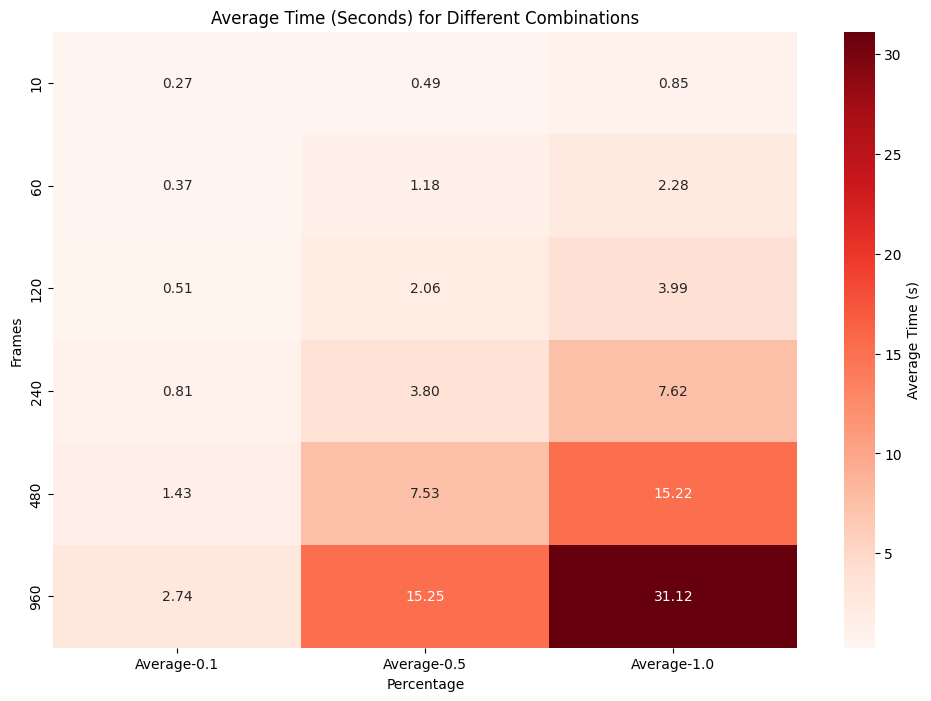

In [19]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_unstacked, annot=True, cmap='Reds', fmt=".2f", cbar_kws={'label': 'Average Time (s)'})
plt.title('Average Time (Seconds) for Different Combinations')
plt.xlabel('Percentage')
plt.ylabel('Frames')
plt.show()

# MAX FPS for uninterrupted animation per combinations

The formula used to get the max FPS, with uninterrupted animation :

$$
Max FPS = \frac{| frames |}{\max(\text{time to generate next matrix})}
$$



In [20]:
max_data = {key: max(value) for key, value in times.items()}

# Calculate the FPS values using the maximum values
fps_values = {key: key[0] / value for key, value in max_data.items()}
fps_values

{(10, 0.1): 33.248255465073235,
 (10, 0.5): 17.856384450660094,
 (10, 1): 10.36618091999737,
 (60, 0.1): 137.14352977849035,
 (60, 0.5): 45.34114740606321,
 (60, 1): 23.923891717917794,
 (120, 0.1): 210.42459391222658,
 (120, 0.5): 53.179910844944374,
 (120, 1): 27.575028000091383,
 (240, 0.1): 266.07807520781216,
 (240, 0.5): 57.955046066304824,
 (240, 1): 29.344914740305278,
 (480, 0.1): 310.8148061693453,
 (480, 0.5): 57.58589755760782,
 (480, 1): 29.664206198676045,
 (960, 0.1): 317.7535628127498,
 (960, 0.5): 58.10203976589616,
 (960, 1): 28.614874227305013}

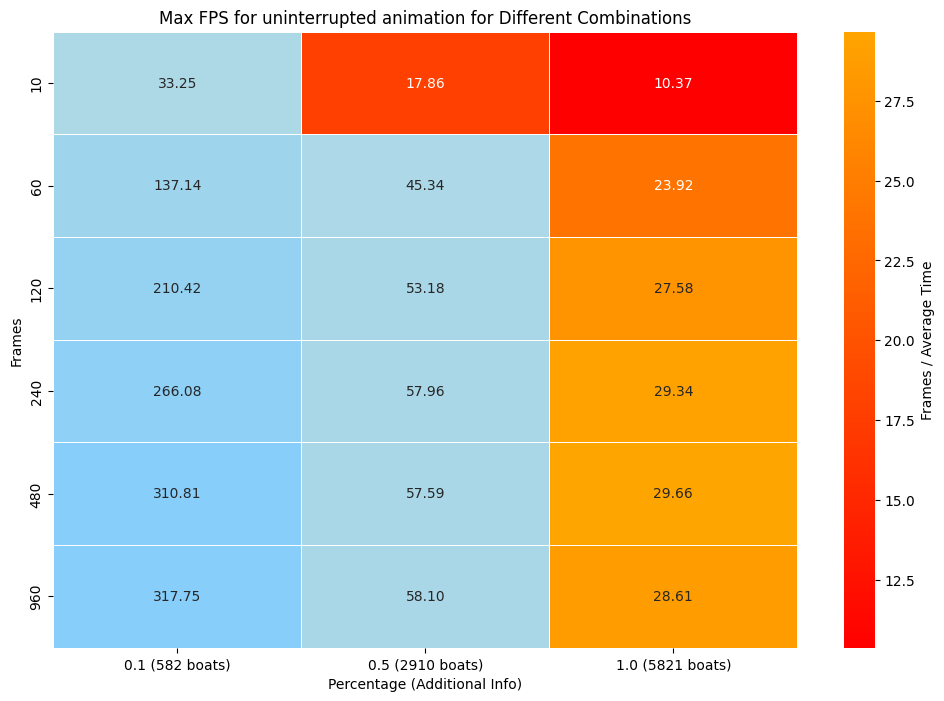

In [22]:
# fps_values = {key: key[0] / value for key, value in avg_data.items()}


df_frames_per_value = pd.DataFrame.from_dict(fps_values, orient='index', columns=['Frames_per_Value'])
df_frames_per_value.index = pd.MultiIndex.from_tuples(df_frames_per_value.index, names=['Frames', 'Percentage'])

df_frames_per_value_unstacked = df_frames_per_value.unstack(level=-1)
df_frames_per_value_unstacked.columns = [f"{col} ({number_of_objects[col]} boats)" for col in df_frames_per_value_unstacked.columns.droplevel(0)]

# for values below 30
colors_below_30 = ["red", "orange"]
cmap_below_30 = LinearSegmentedColormap.from_list("Below30Colormap", colors_below_30)

# above 30
colors_above_30 = ["#ADD8E6", "#87CEFA"]
cmap_above_30 = LinearSegmentedColormap.from_list("Above30Colormap", colors_above_30)

# Create a mask for values below and above 30
mask_below_30 = df_frames_per_value_unstacked >= 30
mask_above_30 = df_frames_per_value_unstacked < 30

# Plot the heatmap with inverted color gradient for values below 30
plt.figure(figsize=(12, 8))
sns.heatmap(df_frames_per_value_unstacked, annot=True, cmap=cmap_below_30, fmt=".2f", cbar_kws={'label': 'Frames / Average Time'}, mask=mask_below_30, linewidths=.5)
light_blue = "#add8e6"  # 
cmap_single_shade = mcolors.ListedColormap([light_blue]) 
sns.heatmap(df_frames_per_value_unstacked, annot=True, cmap=cmap_above_30, fmt=".2f", cbar=False, mask=mask_above_30, linewidths=.5)
plt.title('Max FPS for uninterrupted animation for Different Combinations')
plt.xlabel('Percentage (Additional Info)')
plt.ylabel('Frames')
plt.show()

# Memory occupied on disk by 3 matrices (t-1, t, t+1)

In [23]:
memory_used

{(10, 0.1): 0.4168701171875,
 (10, 0.5): 2.180704116821289,
 (10, 1): 4.510184288024902,
 (60, 0.1): 2.7187366485595703,
 (60, 0.5): 14.488865852355957,
 (60, 1): 29.763100624084473,
 (120, 0.1): 5.5711469650268555,
 (120, 0.5): 29.599886894226074,
 (120, 1): 60.662577629089355,
 (240, 0.1): 11.762939453125,
 (240, 0.5): 61.61973571777344,
 (240, 1): 125.95961856842041,
 (480, 0.1): 24.75767421722412,
 (480, 0.5): 127.56088638305664,
 (480, 1): 260.59914207458496,
 (960, 0.1): 50.78852653503418,
 (960, 0.5): 261.52373027801514,
 (960, 1): 532.4159679412842}

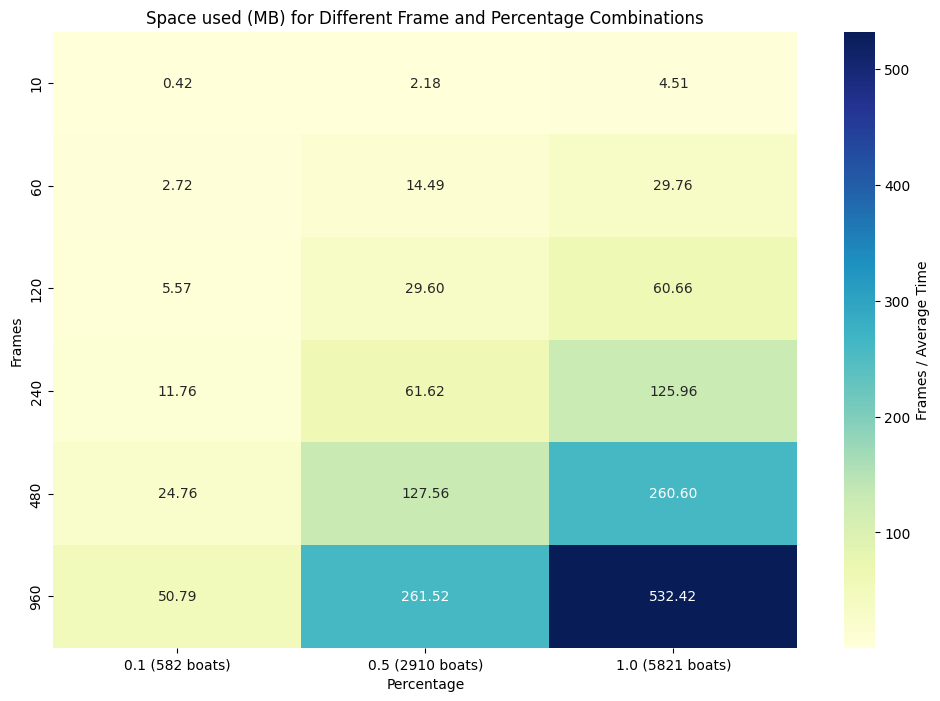

In [24]:


df_frames_per_value = pd.DataFrame.from_dict(memory_used, orient='index', columns=['%'])
df_frames_per_value.index = pd.MultiIndex.from_tuples(df_frames_per_value.index, names=['Frames', 'Percentage'])

df_frames_per_value_unstacked = df_frames_per_value.unstack(level=-1)
df_frames_per_value_unstacked.columns = [f"{col} ({number_of_objects[col]} boats)" for col in df_frames_per_value_unstacked.columns.droplevel(0)]


plt.figure(figsize=(12, 8))
sns.heatmap(df_frames_per_value_unstacked, annot=True, cmap='YlGnBu', fmt=".2f", cbar_kws={'label': 'Frames / Average Time'})
plt.title('Space used (MB) for Different Frame and Percentage Combinations')
plt.xlabel('Percentage')
plt.ylabel('Frames')
plt.show()

# Moving resampling and indexing to database

In [25]:

import numpy as np
from shapely.geometry import Point
from pymeos.db.psycopg import MobilityDB

from pymeos import *
import os
import sys
from datetime import timedelta, datetime
from pymeos import *
import time
from tqdm import tqdm
import itertools
import shutil
import math
import subprocess
from collections import deque

def get_folder_size_mb(dir_name):
    total_size = 0
    sizes = deque(maxlen=3)
    for dirpath, dirnames, filenames in os.walk(dir_name):
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)
            # Skip if it is symbolic link
            if not os.path.islink(file_path):
                sizes.append(os.path.getsize(file_path))
    # Convert size to MB
    total_size_mb = sum(sizes) / (1024 * 1024)
    return total_size_mb

"""
Iterate over all the possible combinations of frames and percentages

for each combination :
    
    Create 3 time deltas
    store : time for each time delta
    store : maximum time for each time delta
    store : average time for each time delta
    
    Calculate FPS using : Frames / maximum time for each time delta

    Store the FPS for each combination

    store the memory used by all 3 time delta in local disk


"""


MATRIX_DIRECTORY_PATH ="/home/ali/matrices/" 
if os.path.exists(MATRIX_DIRECTORY_PATH):
    shutil.rmtree(MATRIX_DIRECTORY_PATH)
    os.makedirs(MATRIX_DIRECTORY_PATH)
else:
    os.makedirs(MATRIX_DIRECTORY_PATH)
pymeos_initialize()

SRID = 4326
DATABASE_NAME = "mobilitydb"
TPOINT_TABLE_NAME = "PyMEOS_demo"
TPOINT_ID_COLUMN_NAME = "MMSI"
TPOINT_COLUMN_NAME = "trajectory"
x_min = -180
y_min = -90
x_max = 180
y_max = 90
extent_list = [x_min, y_min, x_max, y_max]
Time_granularities = {
                    # "MILLISECOND" : timedelta(milliseconds=1),
                      "SECOND" : timedelta(seconds=1),
                      "MINUTE" : timedelta(minutes=1),
                    #   "HOUR" : timedelta(hours=1),
                    }
GRANULARITY = Time_granularities["SECOND"]

connection_params = {
        "host": "localhost",
        "port": 5432,
        "dbname": DATABASE_NAME,
        "user": "postgres",
        "password": "postgres"
        }
                
connection = MobilityDB.connect(**connection_params)
cursor = connection.cursor()

cursor.execute(f"SELECT {TPOINT_ID_COLUMN_NAME} FROM public.{TPOINT_TABLE_NAME};")
Total_ids = cursor.fetchall()

cursor.execute(f"SELECT MIN(startTimestamp({TPOINT_COLUMN_NAME})) AS earliest_timestamp FROM public.{TPOINT_TABLE_NAME};")
start_date = cursor.fetchone()[0]
cursor.execute(f"SELECT MAX(endTimestamp({TPOINT_COLUMN_NAME})) AS latest_timestamp FROM public.{TPOINT_TABLE_NAME};")
end_date = cursor.fetchone()[0]

total_frames = math.ceil( (end_date - start_date) // GRANULARITY ) + 1

timestamps = [start_date + i * GRANULARITY for i in range(total_frames)]
timestamps = [dt.replace(tzinfo=None) for dt in timestamps]
timestamps_strings = [dt.strftime('%Y-%m-%d %H:%M:%S') for dt in timestamps]


TIME_DELTA_COUNT = 10


Frames = [10, 60, 120, 240, 480, 960]
Percentages = [0.1, 0.5,  1]

number_of_objects={} # Store the number of objects for each percentage
times = {} # Store the time for each time delta
memory_used = {} # Store the memory used for each combination

combinations = tqdm(list(itertools.product(Frames, Percentages)))

for combination in combinations:
    combinations.set_description(f"Combination {combination}")
    frame, percentage = combination

    
    ids_list = Total_ids[:int(len(Total_ids)*percentage)]
    number_of_objects[percentage] = len(ids_list)


    # print(combination)
    dir_name = f"/home/ali/matrices/{frame}_{percentage}"
    # print(dir_name)
    os.mkdir(dir_name)
   
    t_deltas = tqdm([(i, (i+frame)-1) for i in range(0, 10*frame, frame)]) 
    # print(t_deltas)
    times[combination] = []
    for delta in t_deltas:
        t_deltas.set_description(f"Time delta {delta}")
        now = time.time()
        x_min,y_min, x_max, y_max = extent_list
        begin_frame, end_frame = delta
        arguments = [begin_frame, end_frame, percentage, x_min, y_min, x_max, y_max]
        arguments = [str(arg) for arg in arguments]
        arguments += [timestamps_strings[begin_frame],  str(len(timestamps)),
                'SECOND',
                dir_name,
                'mobilitydb',
                'pymeos_demo',
                'MMSI',
                'trajectory']
     

        python_path = sys.executable
        process_B_path = f"/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py"
        
        command = [python_path, process_B_path, *arguments]
        result = subprocess.run(command, capture_output=True, text=True)
        print(result)
        
        loaded_matrix = np.load(f"{dir_name}/matrix_{begin_frame}.npy", allow_pickle=True)

        TIME_total = time.time() - now
        times[combination].append(TIME_total)
    size = get_folder_size_mb(dir_name) 
    memory_used[combination] = size
    shutil.rmtree(dir_name)
        
    
    



Combination (10, 0.1):   0%|          | 0/18 [00:00<?, ?it/s]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '0', '9', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/10_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 0.003726959228515625 seconds, 0.11180877685546875 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '10', '19', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:00:10', '86399', 'SECOND', '/home/ali/matrices/10_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 10 created in 0.007315158843994141 seconds, 0.21945476531982422 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '20', '29', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:00:20', '86399', 'SECOND', '/home/ali/matrices/10_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 20 created in 0.00841832160949707 seconds, 0.2525496482849121 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '30', '39', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:00:30', '86399', 'SECOND', '/home/ali/matrices/10_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 30 created in 0.009156227111816406 seconds, 0.2746868133544922 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '40', '49', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:00:40', '86399', 'SECOND', '/home/ali/matrices/10_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 40 created in 0.010172843933105469 seconds, 0.30518531799316406 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '50', '59', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:00:50', '86399', 'SECOND', '/home/ali/matrices/10_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 50 created in 0.011282920837402344 seconds, 0.3384876251220703 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '60', '69', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:01:00', '86399', 'SECOND', '/home/ali/matrices/10_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 60 created in 0.011539459228515625 seconds, 0.34618377685546875 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '70', '79', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:01:10', '86399', 'SECOND', '/home/ali/matrices/10_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 70 created in 0.012575626373291016 seconds, 0.37726879119873047 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '80', '89', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:01:20', '86399', 'SECOND', '/home/ali/matrices/10_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 80 created in 0.012962102890014648 seconds, 0.38886308670043945 frames for 30 fps animation.\n', stderr='')


Combination (10, 0.5):   6%|▌         | 1/18 [00:03<00:51,  3.04s/it]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '90', '99', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:01:30', '86399', 'SECOND', '/home/ali/matrices/10_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 90 created in 0.013287782669067383 seconds, 0.3986334800720215 frames for 30 fps animation.\n', stderr='')


Combination (10, 0.5):   6%|▌         | 1/18 [00:03<00:58,  3.44s/it]


KeyboardInterrupt: 